In [1]:
import re
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt

from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [2]:
spacy_nlp = spacy.load('en_core_web_sm')

In [3]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
stopwords

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

- https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
- https://nlp.stanford.edu/projects/glove/

In [5]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove_data/glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [6]:
train = pd.read_csv('data/toxic/train.csv.zip')
test = pd.read_csv('./data/toxic/test.csv.zip')

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [10]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values
comments_train = train['comment_text']
comments_test = test['comment_text']

In [11]:
comments_train = list(comments_train)

In [12]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords:
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [13]:
texts = [] 

for line in comments_train: 
    texts.append(clean_text(line))

In [14]:
texts

['xplanationwhy edits username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac dont remove template talk page im retired now892053',
 'aww matches background colour im seemingly stuck thanks talk 2151 january 11 2016 ',
 'ey man im trying edit war guy constantly removing relevant information talking edits instead talk page care formatting actual i',
 'orei cant real suggestions improvement wondered section statistics later subsection types accidents think references need tidying exact format ie date format etc later preferences formatting style references want let knowthere appears backlog articles review guess delay reviewer turns listed relevant form eg wikipediagood_article_nominationstransp',
 'ir hero chance remember page th',
 'ongratulations use tools \xa0 t',
 'ocksucker piss w',
 'andalism matt shirvington article reverted dont ban',
 'orry word nonsense offensive im intending write articlewow jump vandalism im merely requesting encyclope

In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [16]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 325610


In [17]:
word_index

{'article': 1,
 'page': 2,
 'wikipedia': 3,
 'like': 4,
 'dont': 5,
 'talk': 6,
 'think': 7,
 'know': 8,
 'edit': 9,
 'people': 10,
 'im': 11,
 'articles': 12,
 'use': 13,
 'time': 14,
 'good': 15,
 'information': 16,
 'want': 17,
 'deletion': 18,
 'sources': 19,
 'way': 20,
 'pages': 21,
 't': 22,
 'new': 23,
 'need': 24,
 'source': 25,
 'section': 26,
 'editing': 27,
 'help': 28,
 'user': 29,
 'edits': 30,
 'find': 31,
 'discussion': 32,
 'deleted': 33,
 'work': 34,
 'point': 35,
 'add': 36,
 'ive': 37,
 'look': 38,
 'read': 39,
 'image': 40,
 'right': 41,
 'fact': 42,
 'fuck': 43,
 'thanks': 44,
 'going': 45,
 'link': 46,
 'said': 47,
 'content': 48,
 'editors': 49,
 'list': 50,
 'blocked': 51,
 'doesnt': 52,
 'block': 53,
 'youre': 54,
 'added': 55,
 'history': 56,
 'thats': 57,
 'place': 58,
 'removed': 59,
 'sure': 60,
 'ask': 61,
 'case': 62,
 'personal': 63,
 'feel': 64,
 'note': 65,
 'cant': 66,
 'better': 67,
 'reason': 68,
 'thank': 69,
 '2': 70,
 'person': 71,
 'believe': 7

In [18]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [19]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [20]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [21]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12274  1268  6795   371  6346  1148]
validation:  [3020  327 1654  107 1531  257]


In [22]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [  102  4499   118 72984    23    39  4425  4997  3305    33  3160  1149
  3554 13301 13301 45477  6296  1013   253    29  3766  2274   837   141
   133  7292   600  4189  4425  2398   141  3766   436  5276   874   102
    70   576 12760     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [23]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="UTF-8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove_data/glove.6B/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [24]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [25]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [26]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          32561100  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

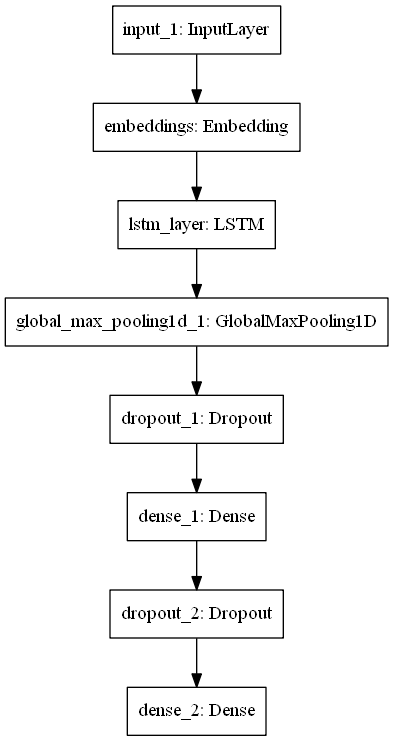

In [27]:
from keras.utils import plot_model
plot_model(model)

In [28]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Train on 127657 samples, validate on 31914 samples
Epoch 1/2
127657/127657 [==============================] - 298s 2ms/step - loss: 0.0818 - accuracy: 0.9737 - val_loss: 0.0654 - val_accuracy: 0.9779
Epoch 2/2
127657/127657 [==============================] - 312s 2ms/step - loss: 0.0670 - accuracy: 0.9773 - val_loss: 0.0618 - val_accuracy: 0.9784


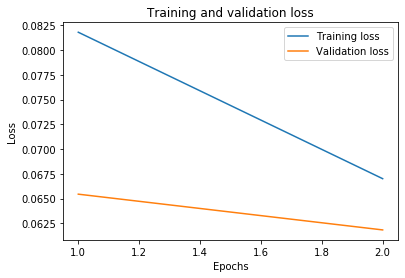

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

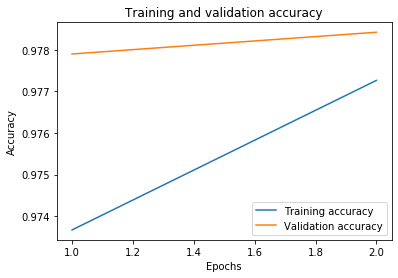

In [30]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();